In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy

import math
import torch
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, ReLU
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import torch
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Data Loader

In [2]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy') 
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')


test_size = 20/100
X_pool, X_val, y_pool, y_val = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

initial_labeled = 100
initial_labeled= 1-initial_labeled/len(X_pool)
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_pool, y_pool, test_size=initial_labeled, stratify=y_pool, random_state=42)


print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_labeled shape: {X_labeled.shape}")
print(f"y_labeled shape: {y_labeled.shape}")
print(f"X_unlabeled shape: {X_unlabeled.shape}")
print(f"y_unlabeled shape: {y_unlabeled.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val  shape: {y_val .shape}")
print(f"X_pool shape: {X_pool.shape}")
print(f"y_pool  shape: {y_pool .shape}")


X shape: (20000, 6, 28)
y shape: (20000,)
X_labeled shape: (100, 6, 28)
y_labeled shape: (100,)
X_unlabeled shape: (15900, 6, 28)
y_unlabeled shape: (15900,)
X_val shape: (4000, 6, 28)
y_val  shape: (4000,)
X_pool shape: (16000, 6, 28)
y_pool  shape: (16000,)


In [3]:
y_sample = y
X_sample = X

# Label distribution
label_counts = Counter(y_sample)
df_labels = pd.DataFrame.from_dict(label_counts, orient='index').sort_index()
df_labels.columns = ['count']
df_labels['percent'] = 100 * df_labels['count'] / len(y_sample)
print("\nLabel distribution:")
print(df_labels)

channel_variance = np.var(X_sample, axis=2).mean(axis=0)
channel_mean = X_sample.mean(axis=(0, 2))
channel_std = X_sample.std(axis=(0, 2))
df_stats = pd.DataFrame({
    'channel': range(6),
    'mean': channel_mean,
    'std_dev': channel_std,
    'variance': channel_variance
})
print("\nMean, Std Dev and Variance per Channel:")
print(df_stats)


Label distribution:
   count  percent
0   9081   45.405
1   2603   13.015
2   8316   41.580

Mean, Std Dev and Variance per Channel:
   channel      mean   std_dev  variance
0        0  0.004546  0.999189  0.730689
1        1  0.004955  0.999538  0.721030
2        2  0.003958  1.000457  0.755685
3        3  0.001807  1.000751  0.783507
4        4  0.001153  1.000271  0.634434
5        5  0.001723  1.000909  0.731176


In [4]:
# Total number of samples
total_samples = sum(label_counts.values())

# Number of classes
num_classes = max(label_counts.keys()) + 1  # assuming labels start from 0

# Compute weight for each class as inverse frequency
class_weights = []
for i in range(num_classes):
    count = label_counts.get(i, 0)
    if count == 0:
        class_weights.append(0.0)  # or very small value like 1e-6
    else:
        class_weights.append(total_samples / (num_classes * count))

# Convert to torch tensor for CE loss
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


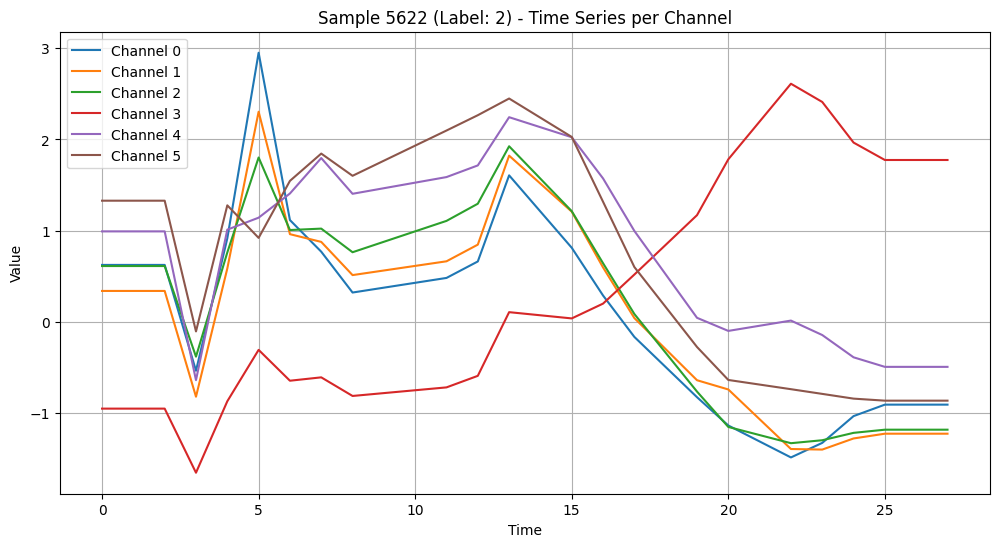

In [5]:
i = np.random.randint(0, len(X))
sample = X[i]  # Shape: (6, T)

plt.figure(figsize=(12, 6))
for c in range(6):
    plt.plot(sample[c], label=f'Channel {c}')
plt.title(f"Sample {i} (Label: {y[i]}) - Time Series per Channel")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Dataloader

In [6]:
class Dataset():
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, index):
        return {
            "x": self.X[index],  # shape: [C, T]
            "y": self.y[index]
        }

    def __len__(self):
        return len(self.X)

In [7]:
train_dataset = Dataset(X_pool, y_pool)
val_dataset = Dataset(X_val, y_val)

# Model

In [8]:
################ CNN Backbone 
def conv_block(in_channels: int, out_channels: int) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
    )
 
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)
        self.global_pool = nn.AdaptiveAvgPool1d((1))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x=self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x
 
################ Fully connected network
class FC(nn.Module):
    def __init__(self,input_dim):
        super(FC, self).__init__()
        self.fco = nn.Linear(input_dim, 3)
    def forward(self, x):
        x=self.fco(x)
        return x


class FullModel(nn.Module):
    def __init__(self, backbone, fc):
        super().__init__()
        self.backbone = backbone
        self.fc = fc

    def forward(self, x):
        feat = self.backbone(x)
        out = self.fc(feat)
        return feat, out

# Loading weights

In [9]:
#pretrained weights
map_location=torch.device(device)

backbone = cnn()
fc = FC(1024)

#loading backbone weights
state_dict = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

backbone.load_state_dict(new_state_dict)

#loading fc weights
state_dict = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

fc.load_state_dict(new_state_dict)

model = FullModel(backbone, fc).to(device)

# Train/eval loop

In [10]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []

    for batch in tqdm(dataloader, desc="Training", leave=False):
        x, y = batch["x"].to(device), batch["y"].to(device)

        optimizer.zero_grad()
        _, out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_targets))
    f1s = sklearn.metrics.f1_score(all_targets, all_preds, average=None)
    return avg_loss, acc, f1s, np.mean(f1s)



def _eval_perf(model, dataloader, device, criterion=None):
    model.eval()
    pred, gt = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validating', leave=False):
            x, y = batch["x"].to(device), batch["y"].to(device)
            _, outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            if criterion:
                total_loss += criterion(outputs, y).item() * len(x)

            pred.extend(preds.cpu().numpy())
            gt.extend(y.cpu().numpy())

    acc = np.mean(np.array(pred) == np.array(gt))
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    avg_f1 = np.mean(f1s)

    if criterion:
        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss, f1s, acc, avg_f1
    else:
        return 0, f1s, acc, avg_f1



# Active Learning Loop

In [11]:
def plot_round_metrics(history):
    round_id = len(history["epoch_metrics"]) - 1
    epoch_stats = history["epoch_metrics"][round_id]
    epochs = list(range(1, len(epoch_stats) + 1))

    train_loss = [e["train_loss"] for e in epoch_stats]
    val_loss = [e["val_loss"] for e in epoch_stats]
    train_acc = [e["train_acc"] for e in epoch_stats]
    train_f1 = [e["train_avg_f1"] for e in epoch_stats]
    val_acc = [e["val_acc"] for e in epoch_stats]
    val_f1 = [e["val_avg_f1"] for e in epoch_stats]

    plt.figure(figsize=(15, 4))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"[Round {round_id+1}] Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"[Round {round_id+1}] Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Avg F1 plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1, label="Train F1")
    plt.plot(epochs, val_f1, label="Val F1")
    plt.title(f"[Round {round_id+1}] Avg F1")
    plt.xlabel("Epoch")
    plt.ylabel("Avg F1")
    plt.legend()

    plt.tight_layout()
    plt.show()



Epoch 1/10


Train   | Loss: 0.4445 | Acc: 0.8532 | Avg F1: 0.8422


Val     | Loss: 0.2983 | Acc: 0.8890 | Avg F1: 0.8898

Epoch 2/10


Train   | Loss: 0.2413 | Acc: 0.9014 | Avg F1: 0.9007


Val     | Loss: 0.2847 | Acc: 0.8928 | Avg F1: 0.8925

Epoch 3/10


Train   | Loss: 0.2035 | Acc: 0.9155 | Avg F1: 0.9154


Val     | Loss: 0.3061 | Acc: 0.8830 | Avg F1: 0.8735

Epoch 4/10


Train   | Loss: 0.1814 | Acc: 0.9237 | Avg F1: 0.9230


Val     | Loss: 0.3112 | Acc: 0.8892 | Avg F1: 0.8904

Epoch 5/10


Train   | Loss: 0.1560 | Acc: 0.9337 | Avg F1: 0.9347


Val     | Loss: 0.3338 | Acc: 0.8892 | Avg F1: 0.8844

Epoch 6/10


Train   | Loss: 0.1315 | Acc: 0.9428 | Avg F1: 0.9447


Val     | Loss: 0.3495 | Acc: 0.8908 | Avg F1: 0.8900

Epoch 7/10


Train   | Loss: 0.1120 | Acc: 0.9514 | Avg F1: 0.9538


Val     | Loss: 0.3684 | Acc: 0.8938 | Avg F1: 0.8918

Epoch 8/10


Train   | Loss: 0.1030 | Acc: 0.9580 | Avg F1: 0.9598


Val     | Loss: 0.4801 | Acc: 0.8808 | Avg F1: 0.8783

Epoch 9/10


Train   | Loss: 0.0797 | Acc: 0.9667 | Avg F1: 0.9683


Val     | Loss: 0.3649 | Acc: 0.8962 | Avg F1: 0.8950

Epoch 10/10


Train   | Loss: 0.0703 | Acc: 0.9700 | Avg F1: 0.9713


Val     | Loss: 0.4390 | Acc: 0.8845 | Avg F1: 0.8848


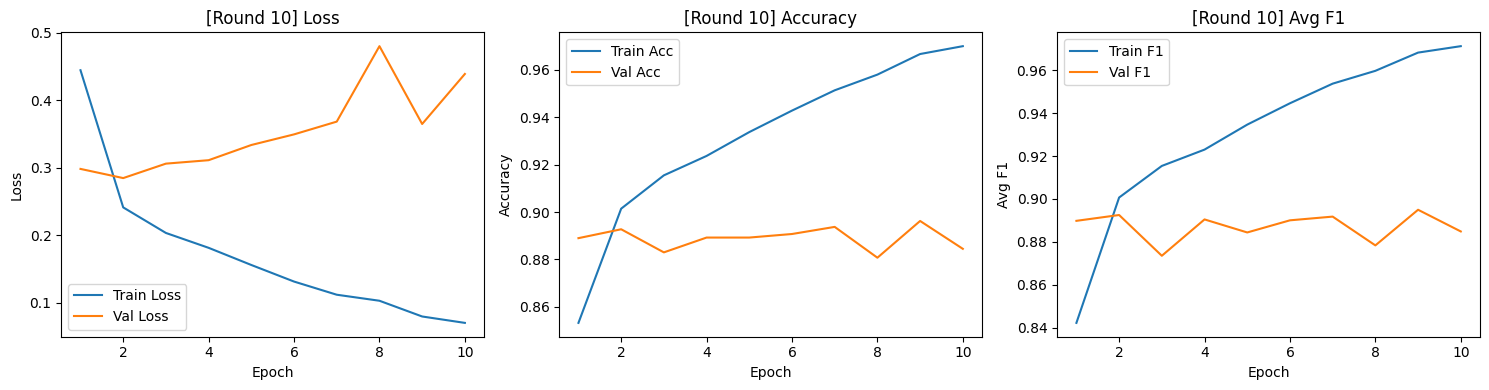

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)


history = {
    "strategy": "Testing",
    "samples": [],
    "epoch_metrics": [],
    "round_val_acc": [],
    "round_val_avg_f1": []
}

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

epoch_stats = []
epochs=10
for ep in range(epochs):
    print(f"\nEpoch {ep+1}/{epochs}")

    tr_loss, tr_acc, tr_f1s, tr_avgf1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Train   | Loss: {tr_loss:.4f} | Acc: {tr_acc:.4f} | Avg F1: {tr_avgf1:.4f}")

    val_loss, val_f1s, val_acc, val_avgf1 = _eval_perf(model, val_loader, device, criterion)
    print(f"Val     | Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Avg F1: {val_avgf1:.4f}")

    epoch_stats.append({
        "train_loss": tr_loss,
        "train_acc": tr_acc,
        "train_avg_f1": tr_avgf1,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_avg_f1": val_avgf1
    })

    history["samples"].append(len(train_dataset))
    history["epoch_metrics"].append(epoch_stats)
    history["round_val_acc"].append(val_acc)
    history["round_val_avg_f1"].append(val_avgf1)

plot_round_metrics(history)


Class   GT     Pred   Acc      F1       IoU     
0       1816   1824   0.8871   0.8852   0.7940  
1       521    479    0.8503   0.8860   0.7953  
2       1663   1697   0.8924   0.8833   0.7910  

Total Accuracy: 0.8845
Macro F1 Score: 0.8848
Mean IoU:       0.7935


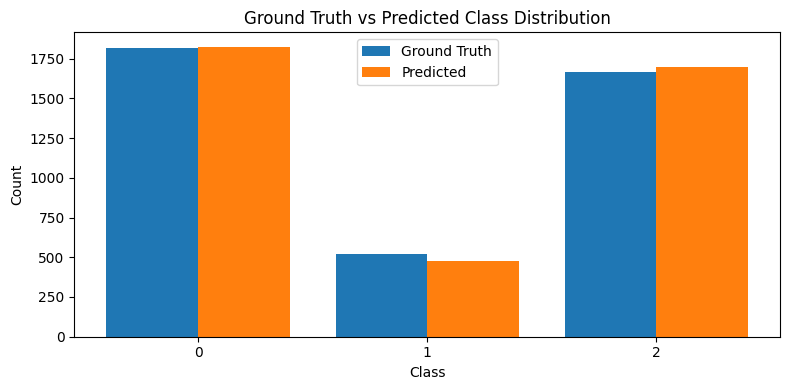

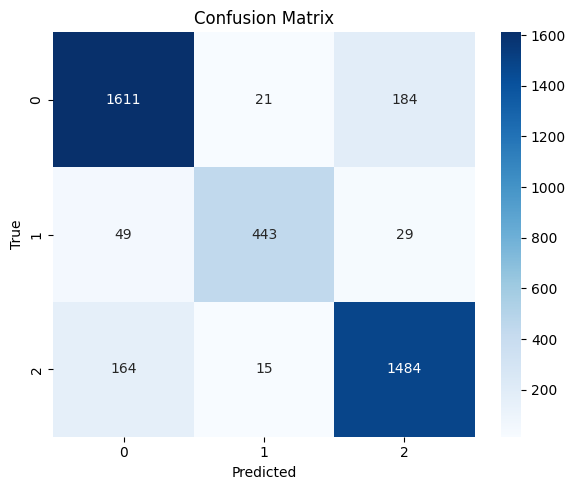

In [13]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def evaluate_detailed(model, dataloader, device, num_classes):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch["x"].to(device), batch["y"].to(device)
            _, out = model(x)
            pred = torch.argmax(out, dim=1)
            preds.append(pred.cpu())
            targets.append(y.cpu())

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    # Confusion matrix
    cm = confusion_matrix(targets, preds, labels=list(range(num_classes)))

    # Metrics
    total_samples_per_class = np.bincount(targets, minlength=num_classes)
    predicted_samples_per_class = np.bincount(preds, minlength=num_classes)

    correct_per_class = np.diag(cm)
    acc_per_class = correct_per_class / (total_samples_per_class + 1e-6)
    f1_per_class = f1_score(targets, preds, average=None, labels=list(range(num_classes)))

    # IoU: TP / (TP + FP + FN)
    iou_per_class = []
    for c in range(num_classes):
        tp = cm[c, c]
        fp = cm[:, c].sum() - tp
        fn = cm[c, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0.0
        iou_per_class.append(iou)

    # Print table
    print(f"{'Class':<7} {'GT':<6} {'Pred':<6} {'Acc':<8} {'F1':<8} {'IoU':<8}")
    for c in range(num_classes):
        print(f"{c:<7} {total_samples_per_class[c]:<6} {predicted_samples_per_class[c]:<6} "
              f"{acc_per_class[c]:<8.4f} {f1_per_class[c]:<8.4f} {iou_per_class[c]:<8.4f}")

    # Summary metrics
    total_acc = np.mean(preds == targets)
    macro_f1 = np.mean(f1_per_class)
    mean_iou = np.mean(iou_per_class)

    print(f"\nTotal Accuracy: {total_acc:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Mean IoU:       {mean_iou:.4f}")

    # Histogram
    plt.figure(figsize=(8, 4))
    bar_width = 0.4
    indices = np.arange(num_classes)
    plt.bar(indices - bar_width/2, total_samples_per_class, width=bar_width, label="Ground Truth")
    plt.bar(indices + bar_width/2, predicted_samples_per_class, width=bar_width, label="Predicted")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Ground Truth vs Predicted Class Distribution")
    plt.xticks(indices)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


evaluate_detailed(model, val_loader, device, num_classes=3)